In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [39]:
experiment = "Unmutated"

In [40]:
csv = f"/Users/alexandranava/Desktop/Spores/GerminationPrediction/Model_Analysis/{experiment.lower()}_sensitivity_featurestd.csv"

df = pd.read_csv(csv)
print(df.columns)
if experiment.lower() == "unmutated":
  true_model_accuracy = 94.4444
  df_test = pd.read_csv("/Users/alexandranava/Desktop/Spores/Data/M4581_s1/Analysis/V3/M4581_s1_Model_Data_V2.csv")
if experiment.lower() == "ktrc":
  true_model_accuracy = 99.0654
  
df['Delta x'] = pd.to_numeric(df['Delta x'], errors='coerce')
df['Accuracy'] = pd.to_numeric(df['Accuracy'], errors='coerce')

df["Change Accuracy"] = true_model_accuracy - df["Accuracy"].astype(float)
df["SI"] = df["Change Accuracy"]/df["Delta x"]

Index(['Feature', 'Accuracy', 'STD', 'Delta x', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6'],
      dtype='object')


### Standardize Feature Sensitivity Analysis


In [41]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def local_sensitivity_analysis(df, feature: str, std_factor: int, use_feature_std: int):
    original_data = df.copy()
    original_color = "blue"
    perturbed_color = "orange"
    # Calculate mean and standard deviation
    feature_stddev: float = np.std(df[feature])
    feature_mean: float = np.mean(df[feature])

    x_min = np.min(df[feature]) - feature_stddev
    x_max = np.max(df[feature]) + feature_stddev
    
    print(rf"{feature.title()} has std = {feature_stddev}...")
    print(rf"{feature.title()} has mean = {feature_mean}...")
    
    # Choosing std to create Gaussian curve to produce noise
    if use_feature_std == 1:
        std = feature_stddev * std_factor
    else: 
        std = std_factor


    ### Adding Noise
    print(f"Using std = {std} to create Gaussian noise...")
    noise = np.random.normal(0, std, df[feature].shape)
    print(f"Adding {df[feature].shape} Gaussian noise samples from {np.min(noise)} to {np.max(noise)}...")
    df[feature] = df[feature] + noise
    
    if use_feature_std ==1: 
        fig, ax = plt.subplots(1, 2, figsize=(14, 4))  # Changed to 2 subplots for distribution plots

        ax[1].hist(original_data[feature], bins=30, alpha=0.25, color=original_color, label = "Original")
        ax[1].hist(df[feature], bins=30, alpha=0.25, color=perturbed_color, label = "Perturbed")
        ax[1].set_title(f"{feature.title()} Distribution", fontsize = 18)
        ax[1].set_xlabel('Value', fontsize = 16)
        ax[1].set_ylabel('Frequency', fontsize = 16)
        ax[1].set_xlim([x_min, x_max])
        ax[1].legend(loc="best")

        # Plot: Noise distribution plot
        ax[0].axvline(x=std, linestyle="--", color='lightgrey', label=rf"+$\sigma$")
        ax[0].axvline(x=-std, linestyle="--", color='lightgrey', label=rf"-$\sigma$")
        ax[0].hist(noise, bins=30, alpha=0.75, color='skyblue', edgecolor="black")
        ax[0].set_title(rf"Noise Distribution with $m_i = {std_factor}$", fontsize = 18)
        ax[0].set_xlabel('Noise Value', fontsize = 16)
        ax[0].set_ylabel('Frequency', fontsize = 16)
        plt.legend()
        plt.show()
    else:
        plt.hist(original_data[feature], bins=30, alpha=0.25, color=original_color, label = "Original")
        plt.hist(df[feature], bins=30, alpha=0.25, color=perturbed_color, label = "Perturbed")
        plt.title(f"{feature.title()} Distribution", fontsize = 16)
        plt.xlabel('Value', fontsize = 16)
        plt.ylabel('Frequency', fontsize = 16)
        plt.xlim([x_min, x_max])
        plt.legend(loc="best", fontsize = 16)

    #Plot: Feature before and after perturbation
    example_spore_perturbed = df[df["SPORE_ID"] == 1]
    example_spore_original = original_data[original_data["SPORE_ID"]==1]
    germination_status = example_spore_original["GERMINATION"].to_list()
    example_germination = germination_status.index(1)    
    plt.figure(figsize=(6, 4))

    sns.lineplot(x=range(0, len(germination_status)), y=example_spore_original[feature], color=original_color, label="Original")
    sns.lineplot(x=range(0, len(germination_status)), y=example_spore_perturbed[feature], color=perturbed_color, label="Perturbed", alpha = 0.5)
    
    plt.axvline(example_germination, color='lightgrey', linestyle='--', label="Germination")
    plt.xlabel("Frame", fontsize = 16)
    plt.ylabel(feature.title(), fontsize = 16)
    plt.title(rf"{feature.title()} of Spore 1 with $m_i = {std_factor}$", fontsize = 18)
    plt.legend(loc="best")
    plt.show()

    delta_x = np.mean(np.abs(original_data[feature] - df[feature]))

    return df, delta_x, 1

Area has std = 63.58600052275756...
Area has mean = 374.62187620146096...
Using std = 63.58600052275756 to create Gaussian noise...
Adding (15606,) Gaussian noise samples from -235.40291061338985 to 266.37749359667913...


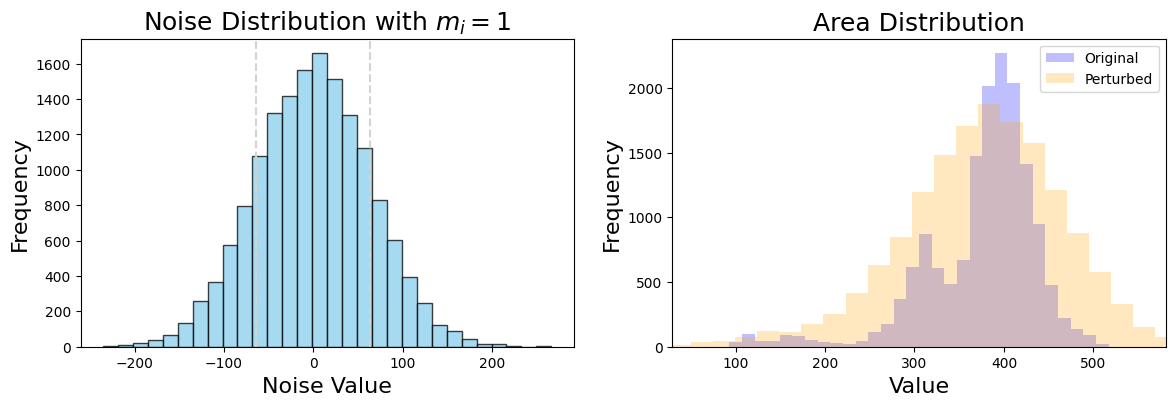

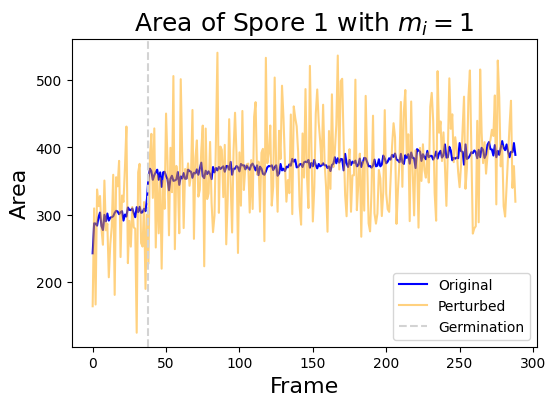

51.20271655238795


In [42]:
_, delta_intensity, perturbed, = local_sensitivity_analysis(df_test, "AREA", 1, 1)
print(delta_intensity)

### Feature Sensitivity Analysis

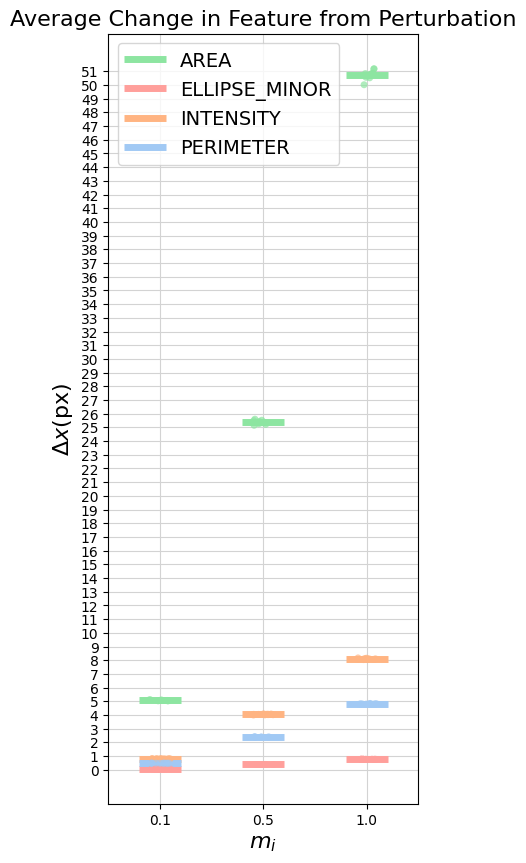

In [43]:
def plot_average_change(df):
  df_plotdeltax = df[["Feature", "STD", "Delta x"]]
  df_plotdeltax = df_plotdeltax.dropna()

  features = df_plotdeltax["Feature"].unique()
  palette = sns.color_palette("pastel", len(features))
  color_dict = dict(zip(features, palette))

  #sns.lineplot(x = "STD", y = "Delta x", data = df, hue = "Feature")
  plt.figure(figsize = (4, 10))
  sns.stripplot(x="STD", y="Delta x", data=df_plotdeltax, alpha=0.7, hue="Feature", palette = color_dict, legend = False)
  mean_values = df_plotdeltax.groupby(["Feature", "STD"])["Delta x"].mean().reset_index()
  sns.pointplot(x="STD", y="Delta x", data=mean_values, hue="Feature", markeredgewidth = 5, markersize = 30, linewidth = 5, linestyle = "none", marker = "_", palette = color_dict)
  plt.xlabel(rf"$m_i$", fontsize = 16)
  plt.ylabel(rf"$\Delta x$(px)", fontsize = 16)
  plt.title(rf"Average Change in Feature from Perturbation", fontsize = 16)
  #plt.yticks(mean_values["Delta x"])
  plt.yticks([num for num in range(int(mean_values["Delta x"].min()), int(mean_values["Delta x"].max())+2)])
  plt.legend(fontsize  = 14)
  plt.grid(color = "lightgrey")
plot_average_change(df)

In [44]:
sigmas = df["STD"].unique()
df_individual_fts = df[~df["Feature"].str.contains("]")]
df_group_fts = df[df["Feature"].str.contains("]")]

def plot_local_sensitivity_accuracy(df):
  #sigmas = df["STD"].unique()
  print(sigmas)


  feature_colors = sns.color_palette("pastel", (len(df["Feature"].unique())))
  mean_changeaccuracy = df.groupby(["Feature", "STD"])["Change Accuracy"].mean().reset_index()
  sns.lineplot(data=mean_changeaccuracy, x="STD", y="Change Accuracy", hue="Feature", marker="o", palette="pastel", markersize = 10, linewidth = 2)

  color_index = 0
  for feature, group in df.groupby(["Feature"]):
      plt.scatter(group["STD"], group["Change Accuracy"], color=feature_colors[color_index], facecolors = "none", s= 20)
      color_index += 1
      #vertical line at each std 
      for sigma in list(sigmas):
        plt.axvline(sigma, color = "lightgrey", linestyle = "--")
      plt.legend(loc = "best")

      #xaxis formatting
      plt.xlabel(r"$\sigma$", fontsize = 16)
      plt.xticks(sigmas, fontsize = 12)
      #yaxis formatting
      plt.ylabel(r"Loss in Accuracy", fontsize = 16)
      plt.yticks([0, 20, 40, 60, 80, 100], ["0%", "20%", "40%", "60%", "80%", "100%"], fontsize = 12)

      plt.legend(fontsize = 12)
      plt.title(f"{experiment} Local Sensitivity Analysis", fontsize = 18)
  plt.show()

[1.  0.1 0.5]


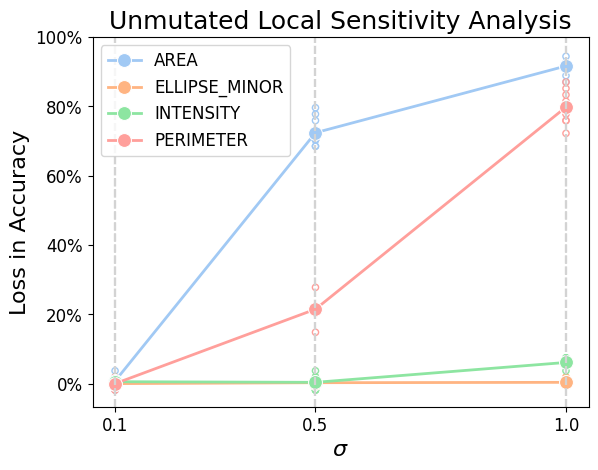

[1.  0.1 0.5]


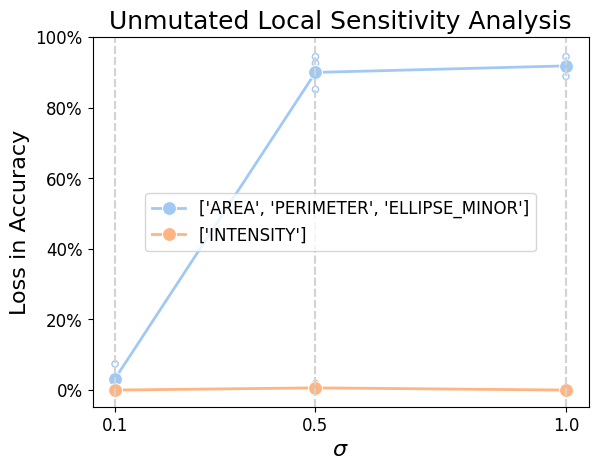

In [45]:
plot_local_sensitivity_accuracy(df_individual_fts)
plot_local_sensitivity_accuracy(df_group_fts)

Finding sigma used to make every normal distibution

[0.1, 0.5, 1.0]
the std of the normal distribution for Area scaled by 0.1 has value: 0.038311259609073695
the std of the normal distribution for Area scaled by 0.5 has value: 0.19155629804536844
the std of the normal distribution for Area scaled by 1.0 has value: 0.3831125960907369


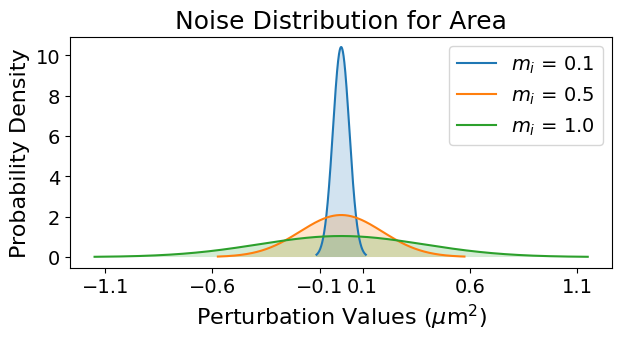

the std of the normal distribution for Intensity scaled by 0.1 has value: 1.0134968757432867
the std of the normal distribution for Intensity scaled by 0.5 has value: 5.067484378716434
the std of the normal distribution for Intensity scaled by 1.0 has value: 10.134968757432867


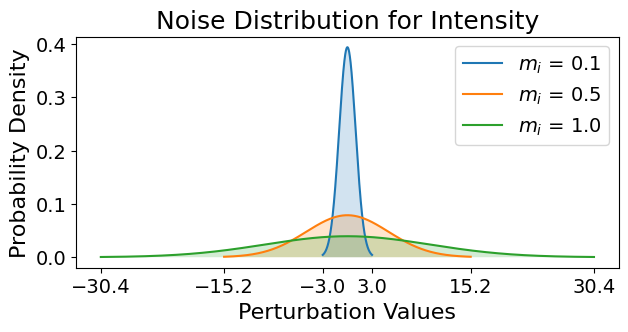

the std of the normal distribution for Perimeter scaled by 0.1 has value: 0.03917246885315193
the std of the normal distribution for Perimeter scaled by 0.5 has value: 0.19586234426575963
the std of the normal distribution for Perimeter scaled by 1.0 has value: 0.39172468853151926


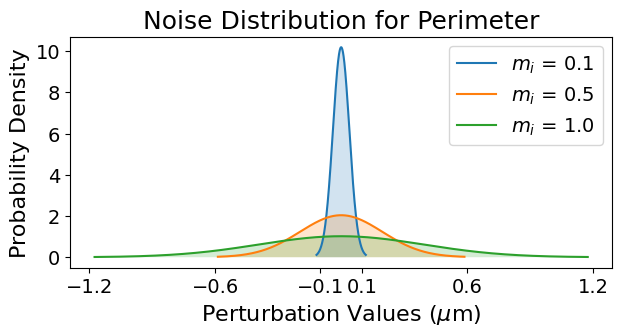

the std of the normal distribution for Ellipse_Minor scaled by 0.1 has value: 0.006277688639018864
the std of the normal distribution for Ellipse_Minor scaled by 0.5 has value: 0.03138844319509432
the std of the normal distribution for Ellipse_Minor scaled by 1.0 has value: 0.06277688639018864


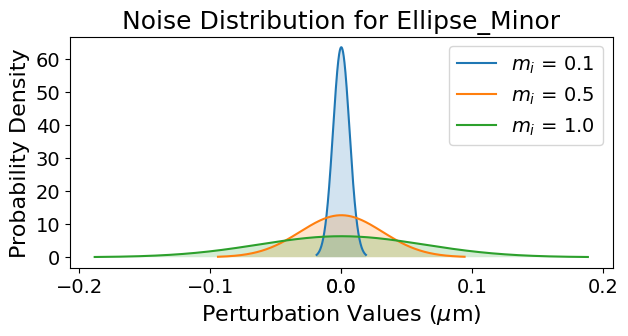

In [46]:
from scipy.stats import norm
local_sensitivity_features = set(df["Feature"].to_list())

sigmas= sorted(sigmas)
print(sigmas)

for feature in local_sensitivity_features:
  if "]" in feature: 
    continue
  feature_stddev: float = np.std(df_test[feature])
  plt.figure(figsize = (7, 3))
  distribution_endpoints = []
  for mi in sigmas:
    scalebar = 0.065
    if "intensity" in feature.lower():
      scalebar = 1
    if "area" in feature.lower():
      scalebar = scalebar**2
    normal_std = mi*feature_stddev*scalebar
    x = np.linspace(-3*normal_std, 3*normal_std, 1000)
    y = norm.pdf(x, 0, normal_std)

    distribution_endpoints.append(x[0])
    distribution_endpoints.append(x[-1])
    plt.plot(x, y, label=rf'$m_i$ = {mi}')
    plt.fill_between(x, y, alpha=0.2)  # Optional: Fill the area under the curve


    print(f"the std of the normal distribution for {feature.title()} scaled by {mi} has value: {normal_std}")
  xticks = np.round(distribution_endpoints, 1)
  plt.xticks(xticks, fontsize=14)
  plt.yticks(fontsize = 14)
  if "area" in feature.lower():
    plt.xlabel(rf"Perturbation Values ($\mu$m$^2$)", fontsize = 16)
  elif "intensity" not in feature.lower():
    plt.xlabel(rf"Perturbation Values ($\mu$m)", fontsize = 16)
  else:
    plt.xlabel(rf"Perturbation Values", fontsize = 16)
  plt.ylabel("Probability Density", fontsize = 16)
  plt.title(f"Noise Distribution for {feature.title()}", fontsize = 18)
  plt.legend(fontsize = 14)
  plt.show()


### Temporal Sensitivity Analysis 

In [47]:
tsa_path_relative = f"/Users/alexandranava/Desktop/Spores/GerminationPrediction/Model_Analysis/{experiment.lower()}_temporal_sensitivity_relative.csv"
tsa_df = pd.read_csv(tsa_path_relative)


Timerange: [-10, 0], Mean Loss in Accuracy: 77.222177778
Timerange: [-3, 0], Mean Loss in Accuracy: 54.62958518600001
Timerange: [0, 10], Mean Loss in Accuracy: 75.5555111111
Timerange: [0, 3], Mean Loss in Accuracy: 31.069914402222228


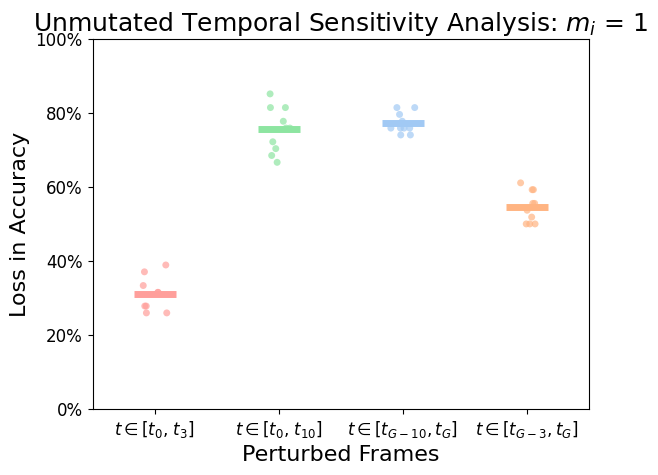

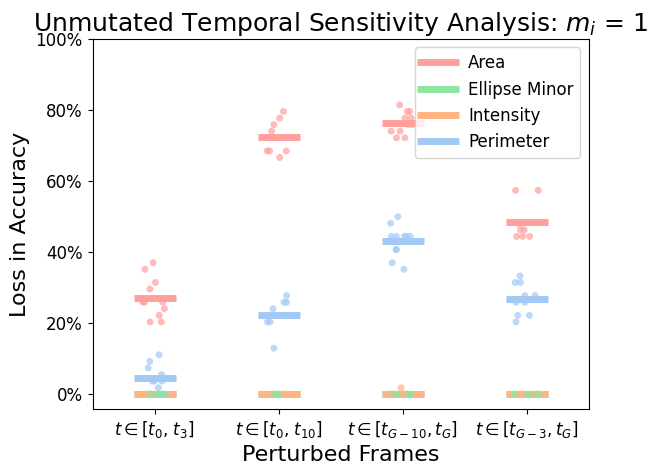

In [48]:

df_tmp_individual_fts = tsa_df[~tsa_df["Feature"].str.contains(",")]
df_tmp_group_fts = tsa_df[tsa_df["Feature"].str.contains(",")]

def plot_temporal_sensitivity_accuracy(df, type):
    # Sort the DataFrame by "TimeRange"
    df = df.sort_values("Timerange")

    # Calculate the loss in accuracy
    df["Loss in Accuracy"] = true_model_accuracy - df["Accuracy"]

    range_order = ['[-3, 0]','[-10, 0]', '[0, 10]', '[0, 3]']
    if type == "group":
        sns.stripplot(x = "Timerange", y = "Loss in Accuracy", data = df, label="Accuracy Loss", alpha = .7, hue = "Timerange", palette = "pastel", order = range_order)
        sns.pointplot(x = "Timerange", y = "Loss in Accuracy", data = df, errorbar = None, linestyle = "none", marker = "_", hue = "Timerange", markeredgewidth = 5, markersize = 30, palette = "pastel", order = range_order)
        
        #sns.stripplot(x = "Timerange", y = "Loss in Accuracy", data = df, label="Accuracy Loss", alpha = .7, color = "lightblue", order = range_order, legend = False)
        #sns.pointplot(x = "Timerange", y = "Loss in Accuracy", data = df, errorbar = None, linestyle = "none", marker = "_", markeredgewidth = 5, markersize = 30, order = range_order, color = "blue", legend = False)

        mean_values = df.groupby("Timerange")["Loss in Accuracy"].mean()
        for timerange, mean_value in mean_values.items():
            print(f"Timerange: {timerange}, Mean Loss in Accuracy: {mean_value}")


    if type == "individual":
        features = df["Feature"].unique()
        palette = sns.color_palette("pastel", len(features))
        color_dict = dict(zip(features, palette))

        sns.stripplot(x="Timerange", y="Loss in Accuracy", data=df, alpha=0.7, hue="Feature", palette=color_dict, order=range_order, legend=False)
        mean_values = df.groupby(["Feature", "Timerange"])["Loss in Accuracy"].mean().reset_index()
        sns.pointplot(x="Timerange", y="Loss in Accuracy", data=mean_values, hue="Feature", markeredgewidth = 5, markersize = 30, palette=color_dict, linewidth = 5, linestyle = "none", marker = "_")

        handles, _ = plt.gca().get_legend_handles_labels()
        custom_labels = [f'{feature.replace("]", "").replace("[", "").replace("_", " ").title()}' for feature in _]
        custom_labels = [feature.replace("'", "") for feature in custom_labels]

        plt.legend(handles=handles, labels=custom_labels, fontsize = 12, loc = "best")


    x_labels = []
    for time_range in range_order:
        time_range = time_range.replace("[", "")
        time_range = time_range.replace("]", "")
        time_range = time_range.split(",")

        if int(time_range[0]) == 0:
            #x_labels.append(f"First {time_range[1]}")
            x_labels.append(rf"$ t \in [t_0$, $t_{{{int(time_range[1])}}}]$")
        if int(time_range[1]) == 0:
            time_range[0] = time_range[0].replace("-", "")
            #x_labels.append(f"Last {time_range[0]}")
            x_labels.append(rf"$ t \in [t_{{G - {int(time_range[0])}}}, t_G]$")

        
    plt.xticks(range_order, x_labels, fontsize = 12)
    plt.yticks([0, 20, 40, 60, 80, 100], ["0%", "20%", "40%", "60%", "80%", "100%"], fontsize = 12)
    # Label the axes
    plt.xlabel("Perturbed Frames", fontsize = 16)
    plt.ylabel("Loss in Accuracy", fontsize = 16)
    plt.gca().invert_xaxis()
    plt.title(rf"{experiment} Temporal Sensitivity Analysis: $m_i$ = {df['Relative STD Scaler'].iloc[0]}", fontsize = 18)
    plt.show()

plot_temporal_sensitivity_accuracy(df_tmp_group_fts, "group")
plot_temporal_sensitivity_accuracy(df_tmp_individual_fts, "individual")

  